### **檔案說明**
* `30Hz20240125_eric.txt`與`30Hz20240125_eric.csv`分別是IMU的轉換前和轉換後的檔案(含有行為標記)

* `0125_eric.txt`與`0125_eric.csv`分別是ECU的原始txt檔與解碼後的csv檔

* `20240125_eric_merged.csv`為ECU與IMU合併後的csv檔

* `20240125_mark_train.csv`與`20240125_mark_test.csv`為IMU與ECU合併之後，校正之前，長度因此縮短的標記column單獨存檔(我用Excel來製作)，一個用於訓練，一個用於測試

* `20240125_Eric_model.pkl`為資料分群後的群中心模型

* `Ridetrack.py`為函數呼叫的主要程式檔案

* `20240125_Eric_clustered.csv`為用訓練好的群中心模型去預測數據的駕駛行為

### **一、導入函式庫**

In [1]:
# 載入要使用的函式庫
import pandas as pd
import Ridetrack
SensorFusion = Ridetrack.SensorFusion()
AutoTag = Ridetrack.AutoTag()
DrivePSTs = Ridetrack.DrivePSTs()
else_ = Ridetrack.else_()

### **二、定義訓練資料的路徑**

In [2]:
# 這裡修改個人的IMU與ECU的資料路徑 (不需要副檔名)
imu_file = r'D:\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\30Hz20240125_eric'
ecu_file = r'D:\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\0125_eric'
train_label_file = r'D:\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240125_mark_train2'
test_label_file = r'D:\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240125_mark_test2'
name_file = '20240125_Eric'  # 命名用

# 一開始閒置的時間(merge完後的檔案：開始幾筆snapshot是Idle)(校正角速度用)
k = 150

### **三、進行資料合併與訓練模型**


Reading 3-axis data in part1 (1/2)


100%|██████████| 13077/13077 [00:10<00:00, 1293.43it/s]



Reading sampling time in part2 (2/2)


100%|██████████| 13076/13076 [00:13<00:00, 947.36it/s] 


Execution time: 0.0 hours 0.0 minutes 30.353332996368408 seconds

【Reverse Engineering Restores ECU Data Part 1 (1/2)】


100%|██████████| 1516/1516 [00:16<00:00, 90.09it/s] 



【Reverse Engineering Restores ECU Data Part 2 (2/2)】


100%|██████████| 1516/1516 [00:13<00:00, 109.74it/s]


Execution time: 0.0 hours 0.0 minutes 30.871073484420776 seconds

【Data Engineering Megre Data Part 1 (1/2)】


100%|██████████| 1515/1515 [00:01<00:00, 882.84it/s]



【Data Engineering Megre Data Part 2 (2/2)】


100%|██████████| 1515/1515 [00:02<00:00, 538.33it/s]


Execution time: 0.0 hours 0.0 minutes 8.420270204544067 seconds


100%|██████████| 11671/11671 [00:00<00:00, 83362.95it/s]


Execution time: 0.0 hours 0.0 minutes 0.822990894317627 seconds
Execution time: 0.0 hours 0.0 minutes 0.6270365715026855 seconds


100%|██████████| 11671/11671 [00:27<00:00, 431.00it/s]


Execution time: 0.0 hours 0.0 minutes 27.978742361068726 seconds
Execution time: 0.0 hours 0.0 minutes 1.7044727802276611 seconds
Execution time: 0.0 hours 1.0 minutes 19.20021390914917 seconds


100%|██████████| 23342/23342 [05:16<00:00, 73.79it/s] 


Execution time: 0.0 hours 5.0 minutes 20.55063009262085 seconds
            index  Go Straight    U-turn       Idle  Turn Right  \
0         Predict    58.374587  56.47482  89.828353   52.845528   
1  Filter_Predict    59.818482  56.47482  94.596313   56.097561   

   Two-Stage Left  Turn Left  Accuracy (Total)  
0           13.75  62.179487         73.642662  
1           12.50  69.871795         76.864830  
| Action         |   Predicted: Go Straight |   Predicted: Idle |   Predicted: Turn Left |   Predicted: Turn Right |   Predicted: Two-Stage Left |   Predicted: U-turn |   Accuracy |
|:---------------|-------------------------:|------------------:|-----------------------:|------------------------:|----------------------------:|--------------------:|-----------:|
| Go Straight    |                     2830 |               976 |                    380 |                     598 |                          26 |                  38 |    58.3746 |
| Idle           |                      1

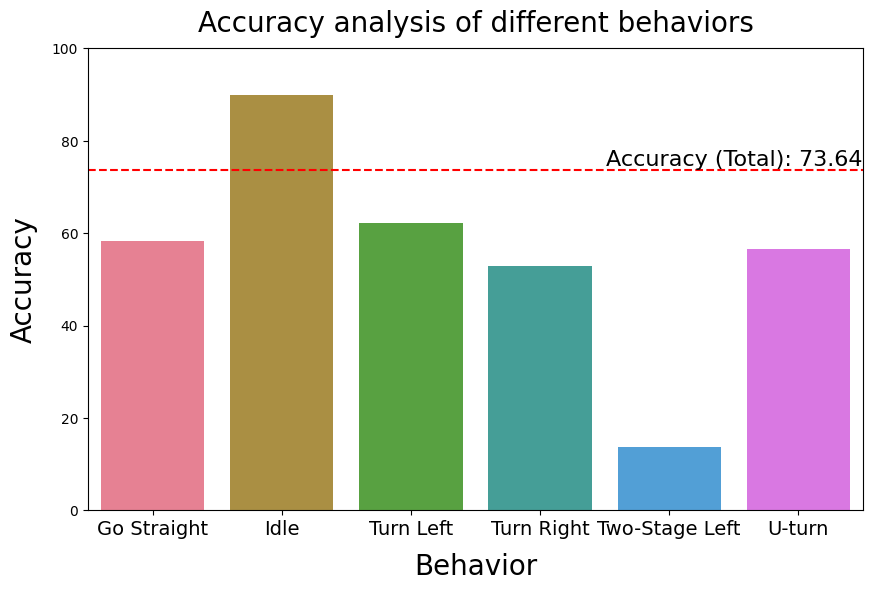

完整的nan行為有10928個
完整的Go Straight行為有26個
完整的U-turn行為有8個
完整的Idle行為有109個
完整的Turn Right行為有4個
完整的Two-Stage Left行為有2個
完整的Turn Left行為有4個


In [3]:
# 處理IMU的RawData，轉成可以使用的.csv檔案
SensorFusion.Axis_Process(f'{imu_file}.txt', f'{imu_file}.csv')

# 處理ECU的RawData，轉成可以使用的.csv檔案
SensorFusion.ECU_Reverse(f'{ecu_file}.txt', f'{ecu_file}.csv')

# 對齊 IMU 與 ECU 成為可以使用的資料集
SensorFusion.Data_Merge(f'{ecu_file}.csv', f'{imu_file}.csv',  f'{name_file}_merged.csv')

#校正歸零角度
df = pd.read_csv(f'{name_file}_merged.csv')
SensorFusion.calibrate_angles(df, f'{name_file}_merged.csv')

#校正歸角速度  (K依每次開始前機車靜置校正不同有所改變)
df = pd.read_csv(f'{name_file}_merged.csv')
SensorFusion.calibrate_imu(df, k, f'{name_file}_merged.csv')


# 正規化
df = pd.read_csv(f'{name_file}_merged.csv')

feature = ['Atmospheric Pressure', 'Inclination Switch',
       'Fault Code Count', 'Ignition Coil Current Diagnosis',
       'Fault Light Mileage', 'Engine Operating Time',
       'Ignition Advance Angle', 'Idling Correction Ignition Angle',
       'Fuel Injection Prohibition Mode', 'Injection Mode',
       'Bypass Delay Correction', 'ABV Opening', 'ABV Idling Correction',
       'ABV Learning Value', 'Lambda Setting', 'Air-Fuel Ratio Rich',
       'Closed Loop Control', 'Air Flow', 'Throttle Valve Air Flow',
       'Intake Manifold Pressure', 'Intake Manifold Front Pressure',
       'MFF_AD_ADD_MMV_REL', 'MFF_AD_FAC_MMV_REL', 'MFF_AD_ADD_MMV',
       'MFF_AD_FAC_MMV', 'Fuel Injection Quantity', 'MFF_WUP_COR',
       'Ignition Mode', 'Engine RPM', 'Engine RPM Limit', 'Idling Target RPM',
       'Fuel Injection Start Angle', 'Fuel Pump State', 'Engine State',
       'Engine Temperature', 'Water Temperature PWM',
       'Ignition Magnetization Time', 'Fuel Injection Time',
       'Closed Loop Fuel Correction', 'Intake Temperature',
       'Combustion Chamber Intake Temperature', 'TPS Opening',
       'TPS Idling Learning Value', 'Battery Voltage', 'O2 Voltage',
       'Vehicle Speed', 'TPS Voltage', 'Seat Switch State', 
       'X-axis Angular Velocity', 'Y-axis Angular Velocity',
       'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration',
       'Z-axis Acceleration', 'X-axis Angle', 'Y-axis Angle', 'Z-axis Angle']


# SensorFusion.normalize_data(df, feature, method="minmax", save_path=f'{name_file}_merged.csv')

# 卡爾曼濾波器(https://pypi.org/project/filterpy/)
df = pd.read_csv(f'{name_file}_merged.csv')
SensorFusion.apply_kalman_filter(df, feature,  q_noise=0.0001, r_noise=0.001, save_path=f'{name_file}_merged.csv')

df = pd.read_csv(f'{name_file}_merged.csv')

feature = ['Z-axis Angular Velocity', 'Z-axis Angle', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angle', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Angle']

# 利用k-means進行分群以得到群中心模型
AutoTag.cluster_data(df, feature, method="kmeans", n_clusters=11, model_path=f'{name_file}_model.pkl', save_path=f'{name_file}_merged.csv')

df = pd.read_csv(f'{name_file}_merged.csv', skip_blank_lines=False)

# 複製資料並附加到尾端
df_doubled = pd.concat([df, df], ignore_index=True)

# 儲存至新的CSV檔案
df_doubled.to_csv(f'{name_file}_merged.csv', index=False)

# 重新加入標記資料
df_train = pd.read_csv(f'{name_file}_merged.csv')
df_test = pd.read_csv(f'{name_file}_merged.csv')
train_label = pd.read_csv(f'{train_label_file}.csv', skip_blank_lines=False)  # skip_blank_lines=False 要把空白值算入
test_label = pd.read_csv(f'{test_label_file}.csv', skip_blank_lines=False)
df_train['Action'] = train_label['Action']
df_test['Action'] = test_label['Action']
# df = df[::5]

DrivePSTs.train_vomm(df_train, 30, 11, False)
Test_Data = DrivePSTs.test_vomm(df_test, 6, save_path=f'{name_file}_merged.csv')

Test_Data = Test_Data.dropna()

print(DrivePSTs.compute_accuracy(Test_Data, 6, None))
DrivePSTs.calculate_action_prediction_counts(Test_Data['Action'], Test_Data['Predict'], True)

# 計算每個完整動作的數量
df = pd.read_csv(f'{name_file}_merged.csv', skip_blank_lines=False)

# 初始化變數
last_action = None
action_counts = {}

# 遍歷每一行
for action in df['Action']:
    # 如果當前行為與上一個行為不同，則開始新的行為
    if action != last_action:
        if action not in action_counts:
            action_counts[action] = 0
        action_counts[action] += 1
    last_action = action

# 輸出結果
for action, count in action_counts.items():
    print(f'完整的{action}行為有{count}個')

### **四、繪製資料點3D散佈圖**

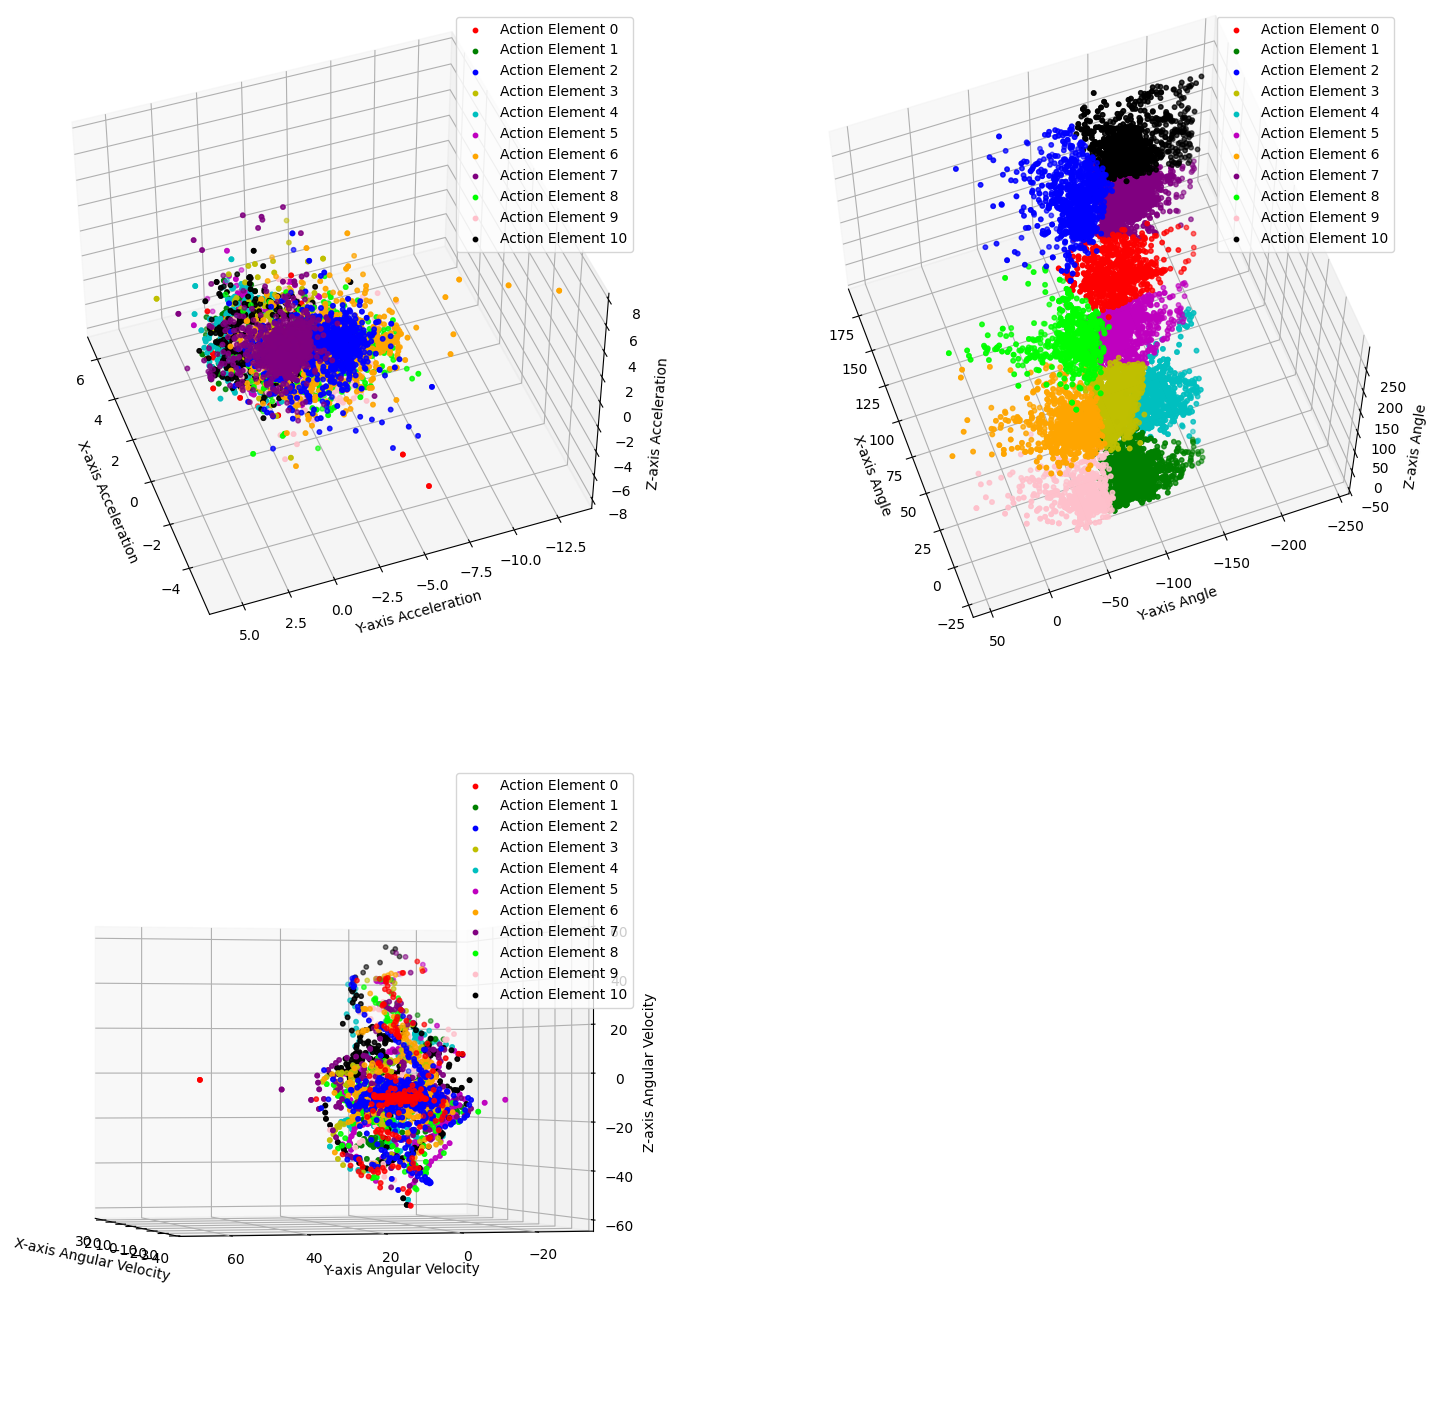

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load the provided CSV file
file_path = '20240125_eric_merged.csv'
data = pd.read_csv(file_path)

# Set up the 3D plot
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(221, projection='3d')
bx = fig.add_subplot(222, projection='3d')
cx = fig.add_subplot(223, projection='3d')

# Group data by 'Action Element' for color coding
groups = data.groupby('Action Element')

# Colors for each 'Action Element'
# colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'lime', 'pink', 'k', 'grey']
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'lime', 'pink', 'k']
# colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'lime', 'pink']

# count = 0  # 為了畫2個群組而已
for (key, group), color in zip(groups, colors):
    ax.scatter(group['X-axis Acceleration'], group['Y-axis Acceleration'], group['Z-axis Acceleration'], c=color, label=f'Action Element {key}', s=10)
    # count += 1
    # if count >= 2:
    #     break

ax.set_xlabel('X-axis Acceleration')
ax.set_ylabel('Y-axis Acceleration')
ax.set_zlabel('Z-axis Acceleration')

for (key, group), color in zip(groups, colors):
    bx.scatter(group['X-axis Angle'], group['Y-axis Angle'], group['Z-axis Angle'], c=color, label=f'Action Element {key}', s=10)

bx.set_xlabel('X-axis Angle')
bx.set_ylabel('Y-axis Angle')
bx.set_zlabel('Z-axis Angle')

# count = 0  # 為了畫2個群組而已
for (key, group), color in zip(groups, colors):
    cx.scatter(group['X-axis Angular Velocity'], group['Y-axis Angular Velocity'], group['Z-axis Angular Velocity'], c=color, label=f'Action Element {key}', s=10)
    # count += 1
    # if count >= 2:
    #     break

cx.set_xlabel('X-axis Angular Velocity')
cx.set_ylabel('Y-axis Angular Velocity')
cx.set_zlabel('Z-axis Angular Velocity')

# Legend
ax.view_init(elev=45, azim=160)  # elev=45, azim=160
bx.view_init(elev=60, azim=160)
cx.view_init(elev=0, azim=165)

ax.legend()
bx.legend()
cx.legend()

plt.show()

### **五、繪製駕駛行為軌跡**

In [ ]:
import Ridetrack
else_ = Ridetrack.else_()

feature = ['Z-axis Angular Velocity', 'Z-axis Angle', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angle', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Angle']

df = pd.read_csv(f'{name_file}_merged.csv')

AutoTag.predict_cluster(df, feature, '20240125_Eric_model.pkl', f'{name_file}_clustered.csv')

df_clustered = pd.read_csv(f'{name_file}_clustered.csv')

else_.Plot_Action_Track(df_clustered, 'Filter_Predict', 250, False)

Execution time: 0.0 hours 0.0 minutes 1.869795322418213 seconds


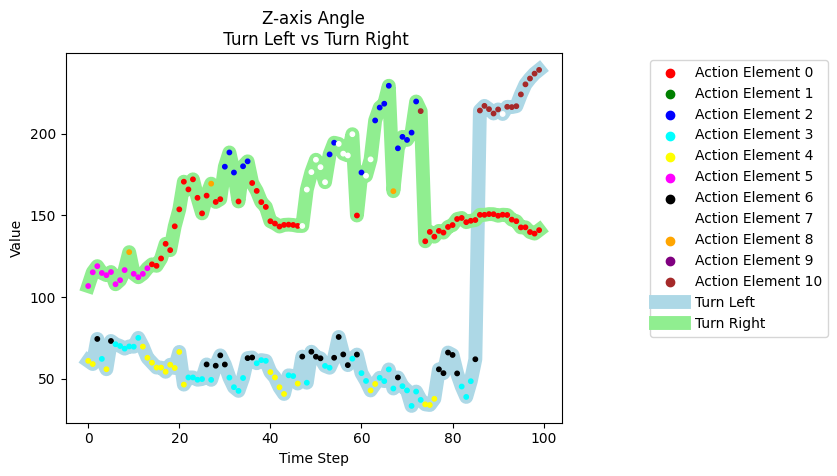

In [5]:
feature = ['Z-axis Angular Velocity', 'Z-axis Angle', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angle', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Angle']

df = pd.read_csv(f'{name_file}_merged.csv')
AutoTag.predict_cluster(df, feature, '20240125_Eric_model.pkl', f'{name_file}_clustered.csv')
df_clustered = pd.read_csv(f'{name_file}_clustered.csv')

else_.Plot_Action_Cluter(df_clustered, 'Turn Left', 'Turn Right', 'Z-axis Angle', 11, 100, False)